# COMENTAR BIEN

In [1]:
from datasets import *
from functions import *

import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
from sklearn import svm

np.random.seed(88)

In [2]:
num_training = 500
num_test = 500

num_layers = 7
learning_rate = 0.05
epochs = 30
batch_size = 24

## We choose a dataset

In [3]:
Xdata, y_train = corners(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = corners(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))

## Functions for the QNN

In [4]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def qcircuit(params, x, y):
    for p in params:
        qml.Rot(*x, wires=0) #This is U(x) (encoding)
        qml.Rot(*p, wires=0) #This is U(theta) (trainable parameters of the NN)

    return qml.expval(qml.Hermitian(y, wires=[0])) # expval(observable) computes the expectation value <state|observable|state>


def cost(params, x, y, state_labels=None):
    
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels] 
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[int(y[i])])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

def test(params, x, y, state_labels=None):
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels] 
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels] 
        best_fidel = np.argmax(fidelities) 

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)

In [5]:
label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False) #These are the two label quantum states

In [6]:
np.random.seed(88)

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# We initialize the neural network with random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True) #The number of parameters is 3*number of layers

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, X_train, y_train, state_labels)

print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format( 0, loss, accuracy_train, accuracy_test))


for it in range(epochs): 
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size): 
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train) 
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Epoch:  0 | Cost: 0.271913 | Train accuracy: 0.576000 | Test Accuracy: 0.544000
Epoch:  1 | Loss: 0.124588 | Train accuracy: 0.836000 | Test accuracy: 0.822000
Epoch:  2 | Loss: 0.102894 | Train accuracy: 0.862000 | Test accuracy: 0.854000
Epoch:  3 | Loss: 0.085808 | Train accuracy: 0.912000 | Test accuracy: 0.882000
Epoch:  4 | Loss: 0.081453 | Train accuracy: 0.910000 | Test accuracy: 0.890000
Epoch:  5 | Loss: 0.081384 | Train accuracy: 0.914000 | Test accuracy: 0.898000
Epoch:  6 | Loss: 0.081736 | Train accuracy: 0.914000 | Test accuracy: 0.896000
Epoch:  7 | Loss: 0.082342 | Train accuracy: 0.910000 | Test accuracy: 0.892000
Epoch:  8 | Loss: 0.083065 | Train accuracy: 0.908000 | Test accuracy: 0.892000
Epoch:  9 | Loss: 0.083589 | Train accuracy: 0.908000 | Test accuracy: 0.890000
Epoch: 10 | Loss: 0.083954 | Train accuracy: 0.908000 | Test accuracy: 0.890000
Epoch: 11 | Loss: 0.084235 | Train accuracy: 0.908000 | Test accuracy: 0.888000
Epoch: 12 | Loss: 0.084449 | Train accur

Cost: 0.084448 | Train accuracy 0.898000 | Test Accuracy : 0.882000
Learned weights
Layer 0: [-0.46406925  0.42846833  0.3183499 ]
Layer 1: [0.24591796 0.44931396 0.06773154]
Layer 2: [1.01270686 0.65053264 1.11618854]
Layer 3: [0.10775809 1.73369326 0.51141802]
Layer 4: [0.55370842 0.75156871 0.01450025]
Layer 5: [0.93829357 1.23884735 0.01476766]
Layer 6: [1.27234106 0.81111828 0.76788018]


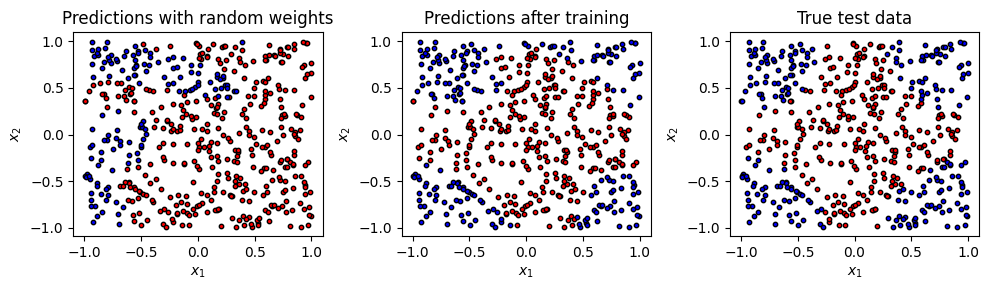

In [7]:
print("Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(loss, accuracy_train, accuracy_test))

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

# QNN+QSVM

In [8]:
def feature_map(params, x, n_qubits):

    for i in range(len(params)):
        for qubit in range(n_qubits):
            qml.Rot(*x, wires=qubit)
            qml.Rot(params[i][0], params[i][1], params[i][2], wires=qubit)

        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])


dev = qml.device("default.qubit", wires = 5)
@qml.qnode(dev)

def circuit(x,y,params, n_qubits): 
    
    feature_map(params,y,n_qubits) 
    qml.adjoint(feature_map)(params,x,n_qubits) 
    return qml.probs(wires = range(n_qubits))


def scalar_product(x,y,params,n_qubits):

    probs = circuit(x,y,params,n_qubits)
    return probs[0] 

def KernelGramMatrixFull(X1,X2,params,n_qubits): 
    
    print("Computing the Gramm matrix")

    gram_matrix = np.zeros((X1.shape[0], X2.shape[0])) 
    for i, x1 in enumerate(X1): 
        print(int(i/len(X1)*100),"%")
        for j, x2 in enumerate(X2):
            x1 = x1.flatten() 
            x2 = x2.flatten()

            gram_matrix[i,j] = scalar_product(x1,x2,params,n_qubits)

    return gram_matrix

In [9]:
n_qubits = 3

clf = svm.SVC(kernel="precomputed") 
matrix = KernelGramMatrixFull(X_train,X_train,params,n_qubits) 
print("Training...")
clf.fit(matrix, y_train) 

print("Testing...")
sol = clf.predict(KernelGramMatrixFull(X_test,X_train,params,n_qubits)) 

success=0
for i in range(len(y_test)):
    if sol[i] == y_test[i]: 
        success += 1

print("Precisión del test: ", success/len(sol)*100, "%")

Computing the Gramm matrix
0 %
0 %
0 %
0 %
0 %
1 %
1 %
1 %
1 %
1 %
2 %
2 %
2 %
2 %
2 %
3 %
3 %
3 %
3 %
3 %
4 %
4 %
4 %
4 %
4 %
5 %
5 %
5 %
5 %
5 %
6 %
6 %
6 %
6 %
6 %
7 %
7 %
7 %
7 %
7 %
8 %
8 %
8 %
8 %
8 %
9 %
9 %
9 %
9 %
9 %
10 %
10 %
10 %
10 %
10 %
11 %
11 %
11 %
11 %
11 %
12 %
12 %
12 %
12 %
12 %
13 %
13 %
13 %
13 %
13 %
14 %
14 %
14 %
14 %
14 %
15 %
15 %
15 %
15 %
15 %
16 %
16 %
16 %
16 %
16 %
17 %
17 %
17 %
17 %
17 %
18 %
18 %
18 %
18 %
18 %
19 %
19 %
19 %
19 %
19 %
20 %
20 %
20 %
20 %
20 %
21 %
21 %
21 %
21 %
21 %
22 %
22 %
22 %
22 %
22 %
23 %
23 %
23 %
23 %
23 %
24 %
24 %
24 %
24 %
24 %
25 %
25 %
25 %
25 %
25 %
26 %
26 %
26 %
26 %
26 %
27 %
27 %
27 %
27 %
27 %
28 %
28 %
28 %
28 %
28 %
28 %
29 %
29 %
29 %
29 %
30 %
30 %
30 %
30 %
30 %
31 %
31 %
31 %
31 %
31 %
32 %
32 %
32 %
32 %
32 %
33 %
33 %
33 %
33 %
33 %
34 %
34 %
34 %
34 %
34 %
35 %
35 %
35 %
35 %
35 %
36 %
36 %
36 %
36 %
36 %
37 %
37 %
37 %
37 %
37 %
38 %
38 %
38 %
38 %
38 %
39 %
39 %
39 %
39 %
39 %
40 %
40 %
40 %
40 %
40 

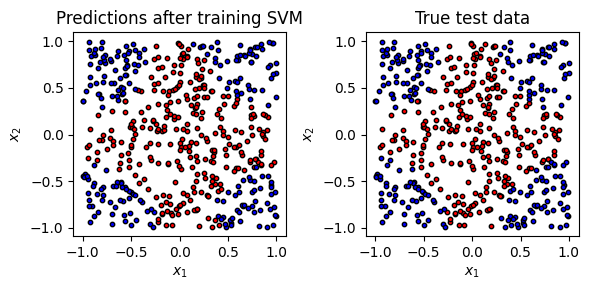

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plot_data(X_test, sol, fig, axes[0])
plot_data(X_test, y_test, fig, axes[1])
axes[0].set_title("Predictions after training SVM")
axes[1].set_title("True test data")
plt.tight_layout()
plt.show()